# Homework 1 - Professionalism and Reproducability

## Data Acquisition

This section obtains the page traffic data for the dinosaur subset articles from Wikipedia for mobile and desktop access type

The three datasets are saved as JSON files ordered using article titles as a key for the resulting analysis.

In [1]:
import json, time, urllib.parse
from os import path
import requests
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

The values of constants such as the API pageviews URL, headers, file from which the titles of the dinosaur articles are imported and the parameters for dates and access types are defined in the following cell .

In [69]:
dinosaur_articles = pd.read_csv('dinosaur_genera.csv')
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is a list of English Wikipedia article titles for dinosaur related artices the that we can use for example requests
ARTICLE_TITLES = list(dinosaur_articles['name'])

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",             # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    
}

The request_pageviews_per_article function hits the api with the provided parameters such as article tile and access type and returns the response in json format

In [70]:
def request_pageviews_per_article(article_title = None,
                                  access=None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
        
    except Exception as e:
        print(e)
        json_response = None
    return json_response

### Dinosaur Pages Monthly Desktop Traffic

The following cell calls the request_pageviews_per_article for every article present in the article subset file with access type as 'dekstop' and writes the response to a json file

In [71]:
filename = 'dino_monthly_desktop_201507-202209.json'
listObj = []
for i in ARTICLE_TITLES:
    views = request_pageviews_per_article(i,'desktop')
    for month in views['items']:
        listObj.append(month)
    with open(filename, 'w') as json_file:
        json.dump(listObj, json_file, 
                        indent=4,  
                        separators=(',',': '))

### Dinosaur Pages Monthly Mobile Traffic

The following cell calls the request_pageviews_per_article twice for every article present in the article subset file for 'mobile-web' and 'mobile-app' access type. The Traffic for both these access types are then combined before writing this output to a json file with access type as 'mobile'

In [72]:
filename = 'dino_monthly_mobile_201507-202209.json'
listObjMobile = []
for i in ARTICLE_TITLES:
    viewsApp = request_pageviews_per_article(i,"mobile-app")
    viewsWeb = request_pageviews_per_article(i,"mobile-web")
    viewsMobile = viewsApp
    for month in viewsWeb['items']:
        ts = month['timestamp']
        vs = month['views']
        for m in viewsMobile['items']:
            if m['timestamp']==ts:
                m['views']+=vs
                m['access']='mobile'

    for month in viewsMobile['items']:
        listObjMobile.append(month)
    with open(filename, 'w') as json_file:
        json.dump(listObjMobile, json_file, 
                        indent=4,  
                        separators=(',',': '))

### Dinosaur Pages Monthly Cumulative Traffic

The following cell calls the request_pageviews_per_article for every article present in the article subset file for 'all-access' access type. This is written to a json file which is then read as a data frame, then I calculated the cumulative sum for views before saving the final data in the required json format.

In [73]:
filename = 'all_access_data.json'
listObjCumulative = []
for i in ARTICLE_TITLES:
    viewsCumulative = request_pageviews_per_article(i,"all-access")
    for month in viewsCumulative['items']:
        listObjCumulative.append(month)
    with open(filename, 'w') as json_file:
        json.dump(listObjCumulative, json_file, 
                        indent=4,  
                        separators=(',',': '))

In [74]:
df_cumulative = pd.read_json('all_access_data.json',convert_dates=False)
df_cumulative.views = df_cumulative.views.cumsum()
df_cumulative.to_json('dino_monthly_cumulative_201507-202209.json', orient='records')

## Data Analysis

This notebook provides a visual analysis for the three datasets generated.

1. Maximum Average and Minimum Average - Time series graph for the dinosaur articles that have the highest average page requests and the lowest average page requests for desktop and mobile access type.
2. Top 10 Peak Page Views - Time series graph for the top 10 dinosaur articles by peak page views for the given time period by access type.
3. Fewest Months of Data - Time series graph to show dinosaur articles that have the fewest months of page traffic data.

The following cell reads the generated json files as dataframes using the pandas library. The timestamp column is formatted appropriately using the datetime library. The format used for the timestamp is %Y-%m-%d

In [50]:
def preprocess(df):
    df.timestamp = df.timestamp/100
    df.timestamp = pd.to_datetime(df.timestamp,format="%Y%m%d")
    return df

df_desktop = pd.read_json('dino_monthly_desktop_201507-202209.json',convert_dates=False)
df_mobile = pd.read_json('dino_monthly_mobile_201507-202209.json',convert_dates=False)
df_desktop,df_mobile = map(preprocess,[df_desktop,df_mobile])


### Maximum Average and Minimum Average

The movingAverage() function calculates the average views for every dinosaur and then appends the names of the dinosaus with the maximum and minimum average traffic over the given period. This function is called twice for both access types.

In [54]:
def movingAverage(df):
    list_dino=[]
    avgViews = df.groupby('article',as_index=False)['views'].mean()
    list_dino.append(avgViews.loc[avgViews['views'] == max(avgViews['views']),['article']].iloc[0][0])
    list_dino.append(avgViews.loc[avgViews['views'] == min(avgViews['views']),['article']].iloc[0][0])
    return list_dino

dino_list = []
dino_list.extend(movingAverage(df_desktop))
dino_list.extend(movingAverage(df_mobile))

dino_list = list(set(dino_list))
print("Desktop Access Type : Dinosaurs with Max and Min average views respectively : ", dino_list)
print("Mobile Access Type : Dinosaurs with Max and Min average views respectively : ", dino_list)



Desktop Access Type : Dinosaurs with Max and Min average views respectively :  ['Tyrannosaurus', 'Honghesaurus']
Mobile Access Type : Dinosaurs with Max and Min average views respectively :  ['Tyrannosaurus', 'Honghesaurus']


The below cell generates the Time Series graph for Maximum and Minimum Average Page Requests by using the list generated above

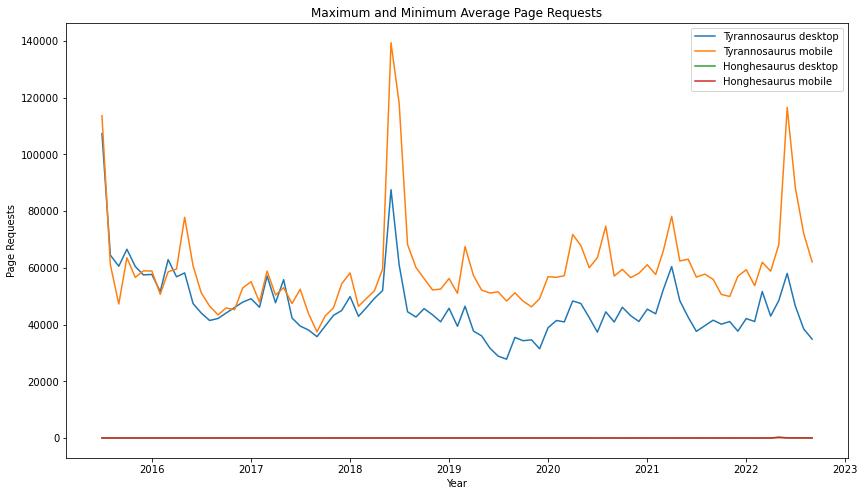

In [18]:
fig = plt.figure(figsize=(14, 8))
for a in dino_list:
    plt.plot(df_desktop.loc[df_desktop.article==a,'timestamp'],df_desktop.loc[df_desktop.article==a,'views'],label=a+' desktop')
    plt.plot(df_mobile.loc[df_mobile.article==a,'timestamp'],df_mobile.loc[df_mobile.article==a,'views'],label=a+' mobile')
plt.title("Maximum and Minimum Average Page Requests")
plt.xlabel("Year")
plt.ylabel("Page Requests")
plt.legend()
plt.savefig("maximum_minimum_average.png", facecolor='white')
plt.show()

### Top 10 Peak Page Views

The below cell finds the top 10 dinosaur articles had the highest peak views for a month and adds the article names to a list. This is generated for both dekstop and mobile access type.

These lists are then used to generate the time series graph.

In [55]:
desktop_peak_views = df_desktop.iloc[df_desktop.groupby(["article"],as_index=False)["views"].idxmax()['views']]
dino_list_desktop = desktop_peak_views.sort_values('views',ascending=False).article.head(10).tolist()

mobile_peak_views = df_mobile.iloc[df_mobile.groupby(["article"],as_index=False)["views"].idxmax()['views']]
dino_list_mobile = mobile_peak_views.sort_values('views',ascending=False).article.head(10).tolist()

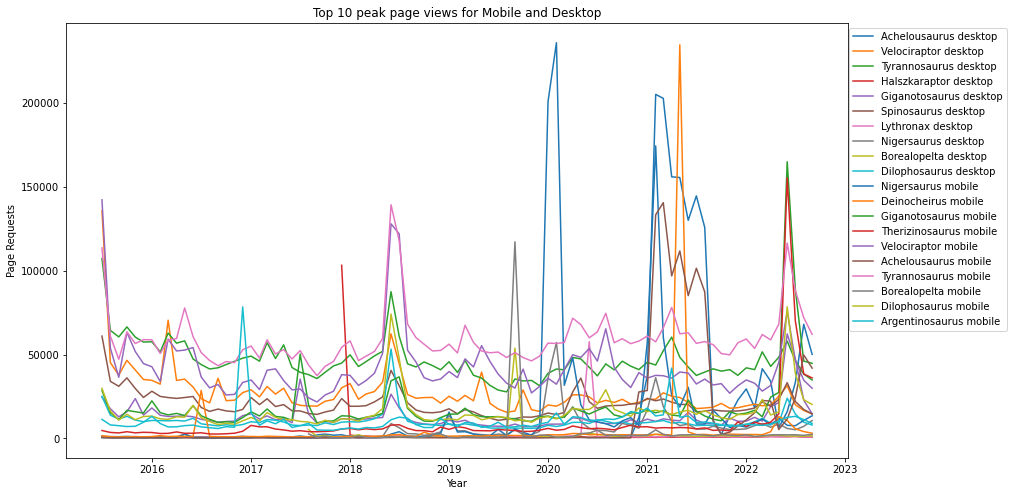

In [36]:
fig = plt.figure(figsize=(14, 8))
for a in dino_list_desktop:
    plt.plot(df_desktop.loc[df_desktop.article==a,'timestamp'],df_desktop.loc[df_desktop.article==a,'views'],label=a+" desktop")
for a in dino_list_mobile:
    plt.plot(df_mobile.loc[df_mobile.article==a,'timestamp'],df_mobile.loc[df_mobile.article==a,'views'],label=a+" mobile")
plt.title("Top 10 peak page views for Mobile and Desktop")
plt.xlabel("Year")
plt.ylabel("Page Requests")
plt.legend(loc='upper right',bbox_to_anchor=(1.21, 1))
plt.savefig("top_10_peak_page_views.png", facecolor='white')
plt.show()

### Fewest Months of Data

The below cell finds the top 10 dinosaur articles with data for the fewest number of months. Again, this is generated for both access types and stored as a list of the article names.

These lists are then used to generate the time series graph.

In [45]:
desktop_month_count = df_desktop.groupby(["article"],as_index=False).size()
dino_list_desktop_month_count = desktop_month_count.sort_values('size',ascending=True).article.head(10).tolist()
print(dino_list_desktop_month_count)

['Mbiresaurus', 'Perijasaurus', 'Jakapil', 'Bisticeratops', 'Iyuku', 'Paralitherizinosaurus', 'Dzharaonyx', 'Bashanosaurus']


In [46]:
mobile_month_count = df_mobile.groupby(["article"],as_index=False).size()
dino_list_mobile_month_count = mobile_month_count.sort_values('size',ascending=True).article.head(10).tolist()
print(dino_list_mobile_month_count)

['Mbiresaurus', 'Perijasaurus', 'Jakapil', 'Bisticeratops', 'Iyuku', 'Paralitherizinosaurus', 'Dzharaonyx', 'Bashanosaurus']


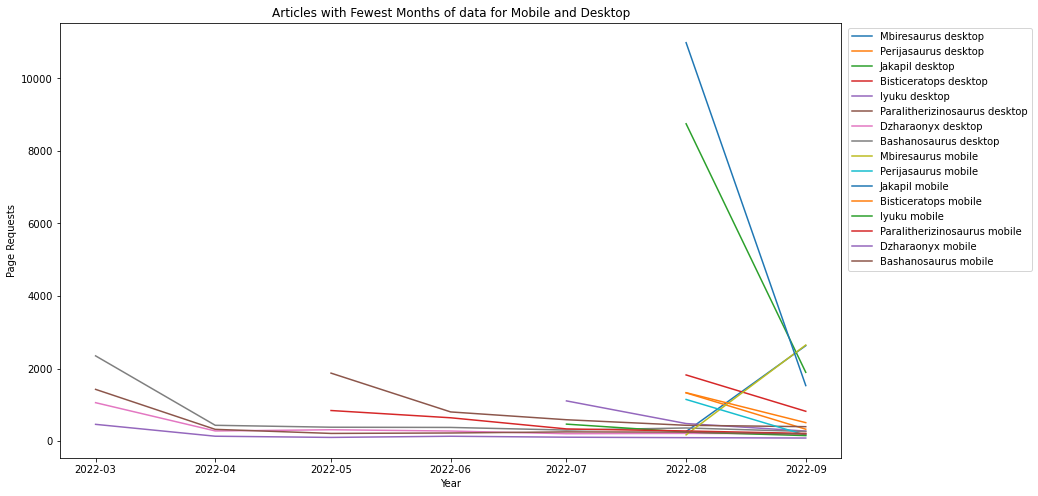

In [49]:
fig = plt.figure(figsize=(14, 8))
for a in dino_list_desktop_month_count:
    plt.plot(df_desktop.loc[df_desktop.article==a,'timestamp'],df_desktop.loc[df_desktop.article==a,'views'],label=a+' desktop')
for a in dino_list_mobile_month_count:
    plt.plot(df_mobile.loc[df_mobile.article==a,'timestamp'],df_mobile.loc[df_mobile.article==a,'views'],label = a+' mobile')
plt.title("Articles with Fewest Months of data for Mobile and Desktop")
plt.xlabel("Year")
plt.ylabel("Page Requests")
plt.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
plt.savefig("fewest_month_views.png", facecolor='white')
plt.show()